# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**: Juan Luis Ivan Estrella Lopez

**Professor**: Pablo Camarillo Ramirez

# Introduction

My pipeline has the objective of determine which Streaming platform is the best, this is due to the excessive ammount of platforms and how multiple movies are divided between these. This would be done by checking the platform a movie is from, their rating, and having an average for each platform.

# Dataset

The dataset is from Kaggle:

https://www.kaggle.com/datasets/javagarm/movies-on-ott-platforms

Which includes 16k movies across platfroms with their respective rating and other metrics. All programs are divided in their respective platform, and sometimes they can be part of both.

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Final Project - Batch Processing") \
    .master("spark://spark-master:7077") \
    .config("spark.ui.port", "4040") \
    .config("spark.jars", "/opt/spark/work-dir/jars/postgresql-42.7.8.jar") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

25/10/28 04:14:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
from IvanE.SparkUtilsIvan import SparkUtils

schema = SparkUtils.generate_schema([
    ("ID","int"),
    ("Title","string"),
    ("Year", "int"),
    ("Age", "string"),
    ("IMDb", "float"),
    ("Rotten Tomatoes", "string"),
    ("Netflix", "string"),
    ("Hulu", "int"),
    ("Prime Video", "int"),
    ("Disney+", "int"),
    ("Type", "int"),
    ("Directors", "string"),
    ("Genres", "string"),
    ("Country", "string"),
    ("Language", "string"),
    ("Runtime", "int")
])

df = spark.read \
                .option("header", "true") \
                .schema(schema) \
                .csv("/opt/spark/work-dir/data/final_project/") 
# df.show()

# Transformations and Actions

In [3]:
from pyspark.sql.functions import col, when, regexp_replace, expr, avg, count, round as spark_round, sum as spark_sum, countDistinct, explode, split, trim, lower

# Data Cleaning
df_clean = df.withColumn(
    "Rotten Tomatoes",
    when(col("Rotten Tomatoes").isNotNull(),
         regexp_replace(col("Rotten Tomatoes"), "%", "").cast("float"))
    .otherwise(None)
)

df_clean = df_clean.withColumn(
    "Netflix",
    when(col("Netflix").isNull(), 0)  
    .otherwise(
        expr("""
            CASE
                WHEN Netflix RLIKE '^[0-9]+$' THEN CAST(Netflix AS INT)
                WHEN Netflix RLIKE '^[0-9]+[.,][0-9]+$' THEN 1
                ELSE 0
            END
        """)
    )
)
# df_clean.show()

In [4]:
avg_imdb = df_clean.select(avg(col("IMDb"))).first()[0]
avg_rt = df_clean.select(avg(col("Rotten Tomatoes"))).first()[0]
avg_runtime = df_clean.select(avg(col("Runtime"))).first()[0]

df_clean = df_clean.fillna({"IMDb": avg_imdb, 
                            "Rotten Tomatoes": avg_rt,
                            "Age": "Unknown",
                            "Directors": "Unknown",
                            "Genres": "Unknown",
                            "Country": "Unknown",
                            "Language": "Unknown",
                            "Runtime": int(avg_runtime)})

# Just making sure I dont have any more null values:
# null_count = df_clean.filter(col("Runtime").isNull()).count()
# print(null_count)


df_clean = df_clean.withColumn("RT_Normalized", col("Rotten Tomatoes") / 10)

df_clean = df_clean.withColumn(
    "Average_Rating",
    spark_round((col("IMDb") + col("RT_Normalized")) / 2, 2)
)

In [5]:
# Table 1: Program Count By Platform
df_long = df_clean.selectExpr(
    "ID", "Title", "Average_Rating",
    "stack(4, 'Netflix', Netflix, 'Hulu', Hulu, 'Prime Video', `Prime Video`, 'Disney+', `Disney+`) as (Platform, Available)"
).filter(col("Available") == 1)

titles_by_platform = (df_long
                      .groupBy("Platform")
                      .agg(count("*").alias("Total_Titles"))
                      .orderBy(col("Total_Titles").desc()))

# titles_by_platform.show()


In [6]:
# Table 2: Ratings for all programs

ratings_by_platform = (df_long
                       .groupBy("Platform")
                       .agg(spark_round(avg("Average_Rating"), 2).alias("Average_Rating"))
                       .orderBy(col("Average_Rating").desc()))

# ratings_by_platform.show()

In [7]:
# Table 3: Best of both worlds (Quantity and Quality)

platform_summary = (df_long
                    .groupBy("Platform")
                    .agg(count("*").alias("Total_Titles"),
                         spark_round(avg("Average_Rating"), 2).alias("Average_Rating"))
                    .orderBy(col("Average_Rating").desc(), col("Total_Titles").desc()))

# platform_summary.show()

In [8]:
# Table 4: Movies for each country

titles_by_country = (df_clean
                     .groupBy("Country")
                     .agg(count("*").alias("Total_Titles"))
                     .orderBy(col("Total_Titles").desc()))

#titles_by_country.show()

In [9]:
# Table 5: Best Genres
genres_split = df_clean.select(explode(split(col("Genres"), ",")).alias("Genre"))
genres_split = genres_split.withColumn("Genre", trim(lower(col("Genre"))))
genre_count = (genres_split
               .groupBy("Genre")
               .count()
               .orderBy(col("count").desc()))

#genre_count.show()


In [10]:
# Table 6: Directors with the most movies

directors_split = df_clean.select(explode(split(col("Directors"), ",")).alias("Director"))
directors_split = directors_split.withColumn("Director", trim(col("Director")))
directors_count = (directors_split
                   .groupBy("Director")
                   .count()
                   .orderBy(col("count").desc()))

# directors_count.show()

# Persistence Data

PostgreSQL was selected because the transformed dataset follows a structured, tabular schema with clearly defined data types and relationships. Its ACID compliance, robust SQL querying, and native support for complex analytical operations

In [11]:
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"
user = "postgres"
password = "Admin@1234"

table_clean = "clean_movies"
table_titles_by_platform = "titles_by_platform"
table_ratings_by_platform = "ratings_by_platform"
table_platform_summary = "platform_summary"
table_titles_by_country = "titles_by_country"
table_genre_count = "genre_count"
table_directors_count = "directors_count"


In [12]:
df_clean.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_clean) \
    .option("user", user) \
    .option("password", password) \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

print("Dataset successfully written to PostgreSQL")


[Stage 9:>                                                          (0 + 1) / 1]

Dataset successfully written to PostgreSQL


In [13]:
titles_by_platform.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_titles_by_platform) \
    .option("user", user) \
    .option("password", password) \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

print("Dataset successfully written to PostgreSQL")




Dataset successfully written to PostgreSQL


In [14]:
ratings_by_platform.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_ratings_by_platform) \
    .option("user", user) \
    .option("password", password) \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

print("Dataset successfully written to PostgreSQL")



Dataset successfully written to PostgreSQL


In [15]:
platform_summary.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_platform_summary) \
    .option("user", user) \
    .option("password", password) \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

print("Dataset successfully written to PostgreSQL")


Dataset successfully written to PostgreSQL


In [16]:
titles_by_country.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_titles_by_country) \
    .option("user", user) \
    .option("password", password) \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

print("Dataset successfully written to PostgreSQL")


Dataset successfully written to PostgreSQL


In [17]:
genre_count.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_genre_count) \
    .option("user", user) \
    .option("password", password) \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

print("Dataset successfully written to PostgreSQL")


[Stage 42:>                                                         (0 + 1) / 1]

Dataset successfully written to PostgreSQL


In [18]:
directors_count.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_directors_count) \
    .option("user", user) \
    .option("password", password) \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

print("Dataset successfully written to PostgreSQL")


Dataset successfully written to PostgreSQL


# DAG

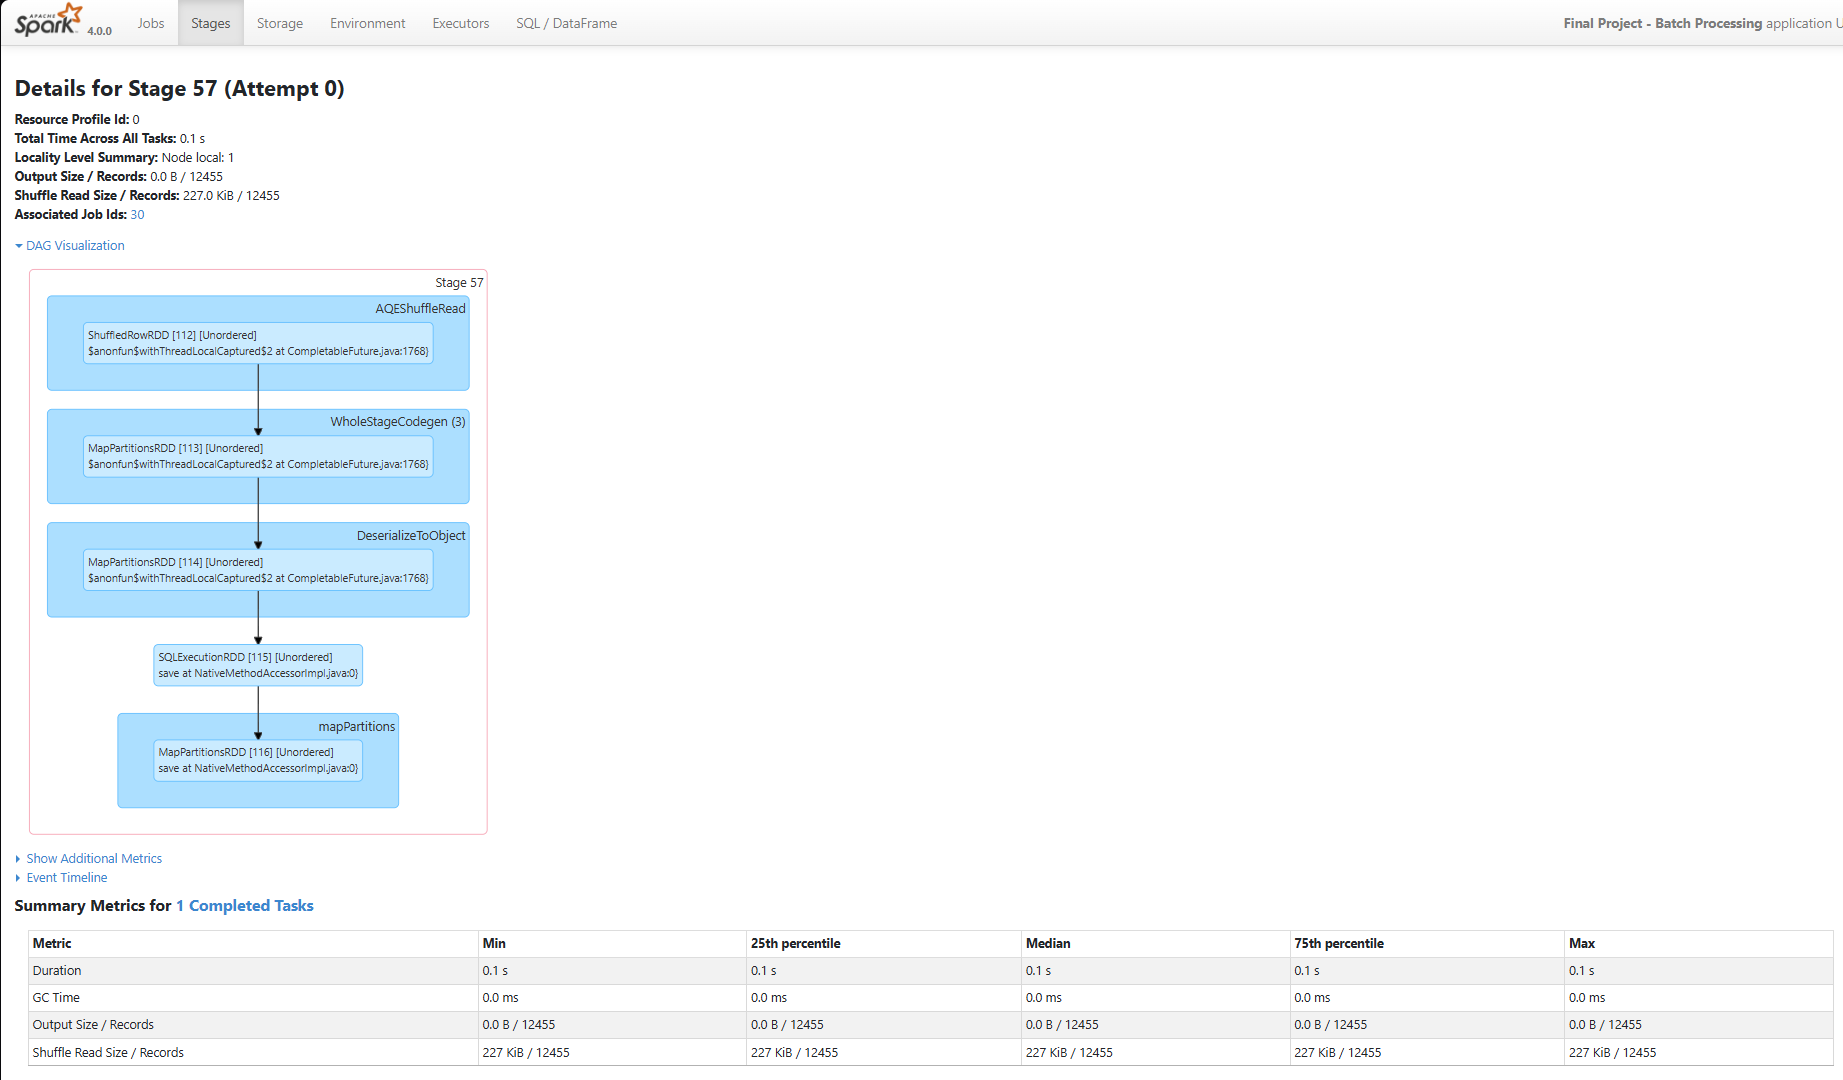

In [ ]:
sc.stop()